In [22]:
from collections import defaultdict, Counter
import elotl.corpus
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm
import os
from re import sub
import graficas as ga
import itertools

In [23]:
corpusNahuatl=elotl.corpus.load('axolotl')  #español-náhuatl 
corpusOtomi=elotl.corpus.load('tsunkua')  #español-otomi 

In [24]:
def getWords(corpus):
    ### Vamos a extraer la lista de palabras para cada lengua en cada corpus: 
    corpusEs=[]
    corpusEx=[] 
    palabras=[] ### Lista temporal
    ### Iteramos sobre cada línea de los corpus y vamos guardando las palabras que corresponden a cada lengua:
    ### Corpus español-náhuatl
    for row in corpus:   
        ### row[0]: corresponde con las oraciones en español
        row[0]=sub(r'[^\w\s]',' ',row[0])     #Sustituimos signos de puntuación por un espacio
        palabras=row[0].lower().split()       #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
        for p in palabras:                    #Iteramos sobre cada palabra de la oración (lista palabras)
            corpusEs.append(p)             #vamos agregando cada palabra a una lista (corpus1_es)
        ### row[1]: corresponde con las oraciones en nahuatl   
        row[1]=sub(r'[^\w\s\']',' ',row[1])  #Sustituimo signos de puntuación por un espacio. Notemos que aparece este signo "'", también lo quitamos.
        palabras=row[1].lower().split()      #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
        for p in palabras:                      #Iteramos sobre cada palabra de la oración (lista palabras)
            corpusEx.append(p)            #vamos agregando cada palabra a una lista (corpus1_na)
    return corpusEs,corpusEx

def fullConcurrencyNetwork(palabras,name=""):
    concDG = nx.DiGraph()
    concDG.add_nodes_from(set(palabras))
    concDG.add_edges_from(zip(palabras[:-1],palabras[1:]))
    if concDG.has_node(" "):
        concDG.remove_node(" ")
    if concDG.has_node(""):
        concDG.remove_node("")
    if name:
        nx.readwrite.graphml.write_graphml(concDG,name)
    return concDG

In [25]:
palabras = getWords(corpusNahuatl)
lenguajes = ["español","Nahuatl"]

In [5]:
for i in range(2):
    print("Lenguaje: {0}".format(lenguajes[i]))
    # número de palabras totales
    print("Palabras totales: {0}".format(len(palabras[i])))
    # número de palabras distintas
    print("Palabras distintas: {0}".format(len(set(palabras[i]))))

Lenguaje: español
Palabras totales: 389137
Palabras distintas: 26691
Lenguaje: Nahuatl
Palabras totales: 286805
Palabras distintas: 51286


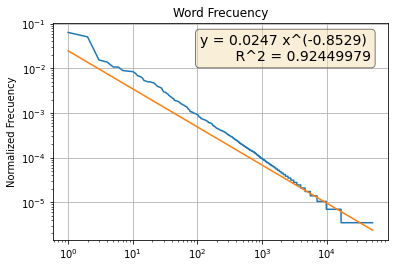

In [6]:
# plotting frecuency
counter = Counter(palabras[1])
vals = counter.most_common()
xs = range(1,len(counter.values())+1)
ys = [val[1] for val in vals]
fig = plt.figure()
ga.plotLogLog(xs,ys,plt.gca(),fit=True)
plt.title("Word Frecuency")
plt.show()

## Building concurrency networks

In [7]:
lang = ["nahuatl","otomi"]
for i,corpus in enumerate([corpusNahuatl,corpusOtomi]):
    palabras = getWords(corpus)
    lenguajes = ["español",lang[i]]
    for j in range(2):
        fullConcurrencyNetwork(palabras[j],os.path.join("networks","full_concurrency_{0}-{1}.graphml".format(lenguajes[j],lang[i])))

## Building network of only spanish

In [8]:
palabras_totales_esp = getWords(corpusNahuatl)[0] + getWords(corpusOtomi)[0]
G = fullConcurrencyNetwork(palabras_totales_esp,os.path.join("networks","full_concurrency_español.graphml"))

## Building network separating by sentences

In [10]:
def processSentence(sentence):
    sentence = sub(r'[^\w\s]',' ',sentence)     #Sustituimos signos de puntuación por un espacio
    sentence = sentence.lower().split()
    return sentence
def getWordsBySentence(corpus):
    corpusEs=[]
    corpusEx=[] 
    for index,row in enumerate(corpus):  
        if (len(row[0].split(" ")) > 1) and (len(row[1].split(" ")) > 1):
            corpusEs.append(processSentence(row[0]))
            corpusEx.append(processSentence(row[1]))
    return corpusEs,corpusEx
def sentenceConcurrencyNetwork(sentencesList,name=""):
    words = [item for lis in sentencesList for item in lis]
    concDG = nx.DiGraph()
    concDG.add_nodes_from(set(words))
    for sentence in sentencesList:
        concDG.add_edges_from(zip(sentence[:-1],sentence[1:]))
    if concDG.has_node(" "):
        concDG.remove_node(" ")
    if concDG.has_node(""):
        concDG.remove_node("")
    if name:
        nx.readwrite.graphml.write_graphml(concDG,name)
    return concDG

In [11]:
lang = ["nahuatl","otomi"]
for i,corpus in enumerate([corpusNahuatl,corpusOtomi]):
    oraciones = getWordsBySentence(corpus)
    lenguajes = ["español",lang[i]]
    for j in range(2):
        sentenceConcurrencyNetwork(oraciones[j],os.path.join("networks","sentence_concurrency_{0}-{1}.graphml".format(lenguajes[j],lang[i])))

In [12]:
G = sentenceConcurrencyNetwork(getWordsBySentence(corpusNahuatl)[0])

## Buiding network cuentos network

In [13]:
def getCuentos():
    cuentosEsp = []
    cuentosNah = []
    folder = "corpusCuentos"
    files = [os.path.join(folder,val) for val in os.listdir(folder) if os.path.isfile(os.path.join(folder,val))]
    for file in files:
        f = open(file,"r",errors="replace")
        l = f.read().split("\n")
        if file.split(os.path.sep)[1][0:3]=="esp":
            cuentosEsp.append([x for x in l if bool(x)])
        elif file.split(os.path.sep)[1][0:3]=="nah":
            cuentosNah.append([x for x in l if bool(x)])
        f.close()
    return cuentosEsp, cuentosNah

def getSentences(cuentos):
    f = []
    for cuento in cuentos:
        c = []
        for par in cuento:
            sentences = par.split(".")
            sentences = [sub(r"[^\w\s]", " ",sen) for sen in sentences if bool(sen)]
            c.extend(sentences)
        f.append(c)
    return f

def buildConcurrencyNetwork(sentencesList,name=""):
    words = [item for lis in sentencesList for item in lis]
    concDG = nx.DiGraph()
    concDG.add_nodes_from(set(words))
    for sentence in sentencesList:
        concDG.add_edges_from(zip(sentence[:-1],sentence[1:]))
    if concDG.has_node(" "):
        concDG.remove_node(" ")
    if concDG.has_node(""):
        concDG.remove_node("")
    if name:
        nx.readwrite.graphml.write_graphml(concDG,os.path.join("networks","{0}.graphml".format(name)))
    return concDG

In [14]:
cuentosEsp, cuentosNah = getCuentos()
cuentosEsp, cuentosEsp = getSentences(cuentosEsp), getSentences(cuentosNah)
cuentosEsp = [item.split(" ") for l in cuentosEsp for item in l]
cuentosNah = [item.split(" ") for l in cuentosNah for item in l]

In [15]:
G = sentenceConcurrencyNetwork(cuentosEsp,os.path.join("networks","sentence_concurrency_cuentos_español.graphml"))
sentenceConcurrencyNetwork(cuentosNah,os.path.join("networks","sentence_concurrency_cuentos_nahuatl.graphml"))

## building bipartite network

In [27]:
cuentosEsp, cuentosNah = getCuentos()
cuentosEsp, cuentosNah = getSentences(cuentosEsp), getSentences(cuentosNah)
G = nx.DiGraph()
ncuentos = len(cuentosEsp)
i = 1
n1 = len(cuentosEsp[i]) 
n2 = len(cuentosNah[i])
if n1 == n2:
    for j in range(n1):
        nodesEsp = cuentosEsp[i][j].split(" ")
        nodesNah = cuentosNah[i][j].split(" ")
        G.add_nodes_from([(n,{"lang":"esp"}) for n in nodesEsp])
        G.add_nodes_from([(n,{"lang":"nah"}) for n in nodesNah])
        G.add_edges_from(itertools.product(nodesEsp,nodesNah))
        G.add_edges_from(itertools.product(nodesNah,nodesEsp,))
        G.add_edges_from(zip(nodesEsp[:-1],nodesEsp[1:]))
        G.add_edges_from(zip(nodesNah[:-1],nodesNah[1:]))
if G.has_node(" "):
    G.remove_node(" ")
if G.has_node(""):
    G.remove_node("")
nx.write_graphml(G,os.path.join("networks","cuento1_concurrency_bipart.graphml"))

In [28]:
cuentosEsp, cuentosNah = getCuentos()
cuentosEsp, cuentosNah = getSentences(cuentosEsp), getSentences(cuentosNah)
G = nx.DiGraph()
ncuentos = len(cuentosEsp)
for i in range(ncuentos):
    n1 = len(cuentosEsp[i]) 
    n2 = len(cuentosNah[i])
    if n1 == n2:
        for j in range(n1):
            nodesEsp = cuentosEsp[i][j].split(" ")
            nodesNah = cuentosNah[i][j].split(" ")
            G.add_nodes_from([(n,{"lang":"esp"}) for n in nodesEsp])
            G.add_nodes_from([(n,{"lang":"nah"}) for n in nodesNah])
            G.add_edges_from(itertools.product(nodesEsp,nodesNah))
            G.add_edges_from(itertools.product(nodesNah,nodesEsp))
            G.add_edges_from(zip(nodesEsp[:-1],nodesEsp[1:]))
            G.add_edges_from(zip(nodesNah[:-1],nodesNah[1:]))
if G.has_node(" "):
    G.remove_node(" ")
if G.has_node(""):
    G.remove_node("")
nx.write_graphml(G,os.path.join("networks","cuentos_concurrency_bipart.graphml"))

In [26]:
palEsp,palNah = getWordsBySentence(corpusNahuatl)
G = nx.DiGraph()
n = len(palEsp)
for i in range(n):
    G.add_nodes_from([(n,{"lang":"esp"}) for n in palEsp[i]])
    G.add_nodes_from([(n,{"lang":"nah"}) for n in palNah[i]])
    G.add_edges_from(itertools.product(palEsp[i],palNah[i]))
    G.add_edges_from(itertools.product(palNah[i],palEsp[i]))
    G.add_edges_from(zip(palEsp[i][:-1],palEsp[i][1:]))
    G.add_edges_from(zip(palNah[i][:-1],palNah[i][1:]))
if G.has_node(" "):
    G.remove_node(" ")
if G.has_node(""):
    G.remove_node("")
nx.write_graphml(G,os.path.join("networks","elotl_nah_concurrency_bipart.graphml"))